In [1]:
import gym
import numpy as np
from matplotlib import pyplot as plt
from collections import defaultdict
from pprint import pprint
import matplotlib.image as image
plt.rcParams["figure.figsize"] = (8, 8)

In [2]:
class MazeEnvironment(gym.Env):
    
    ACTIONS = {0: np.array([0, 1]),
               1: np.array([0, -1]),
               2: np.array([1, 0]),
               3: np.array([-1, 0])}
    rgb_values = {'red': [1,0,0],
                  'blue': [0,0,1],
                  'yellow': [1,1,0],
                  'green': [0,1,0]}
    
    def find_pixels(self, colour):
        coords = np.all(self.field == np.array([[self.rgb_values[colour]]]), axis=2).nonzero()
        return set(zip(*coords))
    
    def identify(self, pos):
        x, y = pos
        if (x >= self.WIDTH or y >= self.HEIGHT or x < 0 or y < 0):
            return 'out_of_field'
        if self.blank_mask[x,y]:
            return 'blank'
        elif self.walls_mask[x,y]:
            return 'wall'
        elif pos in self.coins:
            return 'coin'
        elif pos in self.exits:
            return 'exit'
        elif pos in self.blues:
            return 'blue'
        elif pos in self.start:
            return 'start'
        else:
            raise Exception('Unknown pixel identifier at', pos)
            
    def observation_func(self):
        x, y = self.state
        f = 0
        if (x+1,y) not in self.coins_collected and (x+1,y) in self.coins or \
        (x-1,y) not in self.coins_collected and (x-1,y) in self.coins or \
        (x,y+1) not in self.coins_collected and (x,y+1) in self.coins or \
        (x,y-1) not in self.coins_collected and (x,y-1) in self.coins:
            f = 1
        return x, y, f
    
    
    def get_objects(self):
        # finds the coordinates of the Seeker(red), coins(yellow), traps(blue) and exit(green)
        self.walls_mask = np.all(self.field == np.array([[[1,1,1]]]), axis=2) # black
        self.blank_mask = np.all(self.field == np.array([[[0,0,0]]]), axis=2) # white
        self.coins = self.find_pixels(colour='yellow')
        self.exits = self.find_pixels(colour='green')
        self.blues = self.find_pixels(colour='blue')
        self.start = self.find_pixels(colour='red')
        
    
    # -----------------------------------
    
    def __init__(self, field):
        self.field = field
        self.HEIGHT, self.WIDTH, _ = self.field.shape 
        # up down right left
        self.action_space = gym.spaces.Discrete(4)
        # pos.x, pos.y, flag(is there a coin nereby)
        self.observation_space = gym.spaces.Box(low=np.array([0,0,0], dtype=int), 
                                                    high=np.array([self.HEIGHT, self.WIDTH, 1], dtype=int))
        self.reset()
        
        
    def step(self, action):
        done = False
        reward = -1
        self.state = tuple(np.array(self.state) + self.ACTIONS[action]) # apply action
        
        standing_on = self.identify(self.state)
        if standing_on == 'wall':
            done = True
            reward = -100
#             print('Stepped on a Wall')
        elif standing_on == 'coin' and self.state not in self.coins_collected: 
            reward = 50
            self.coins_collected.add(self.state)
#             print(f'Coin {self.state} is collected')
        elif standing_on == 'exit':
            done = True
            reward = 100
        elif standing_on == 'blue':
            pass
        
        observation = self.observation_func()
        info = {'observation': self.state, 'standing': standing_on}
        return observation, reward, done, info
        
    
    def reset(self, start=None):
        self.get_objects()
        self.coins_collected = set()
        
        if start is None:
            assert len(self.start) == 1, f'There must be only one red point, not {len(red_pixels)}'
            self.state = tuple(self.start)[0] # current coordinates (x, y)
        else:
            self.state = start
        return self.observation_func()
    
    def render(self, model=None, show_labels=True, flag=0):
        if model is None:
            plt.imshow(self.field)
        else:
            path = model.solve()
            fig, ax = plt.subplots()
            cmap = np.linspace([1,0,1], [0,1,1], len(path))
            path_overlay = np.copy(self.field)
            for ind, point in enumerate(path):
                path_overlay[point[0], point[1], :] = cmap[ind]
            if show_labels:
                directions = np.argmax(model.Q[:,:,flag,:], axis=2)
                mask = np.all(model.Q[:,:,flag,:] == np.array([[0,0,0,0]]), axis=2)
                words = {2: 'down', 3: 'up', 1: 'left', 0: 'right'}
                for (j,i),label in np.ndenumerate(directions):
                    ax.text(i, j, f'{words[label]}\n{label:.2f}' if not mask[j,i] else '?',
                            ha='center', va='center', color='#86B0B8')
            ax.imshow(path_overlay)
            plt.show()

In [8]:
img = image.imread('tracks/track2.png')[:,:,:3]
print('The Shape of the image is:', img.shape)
env = MazeEnvironment(img)

The Shape of the image is: (20, 20, 3)


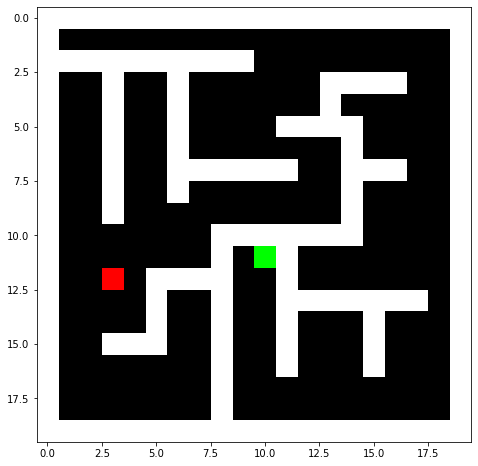

In [9]:
env.render()